<ipython-input-1-cbbf660bfbdd>:83: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("Speed (mph)").apply(lambda x: x)


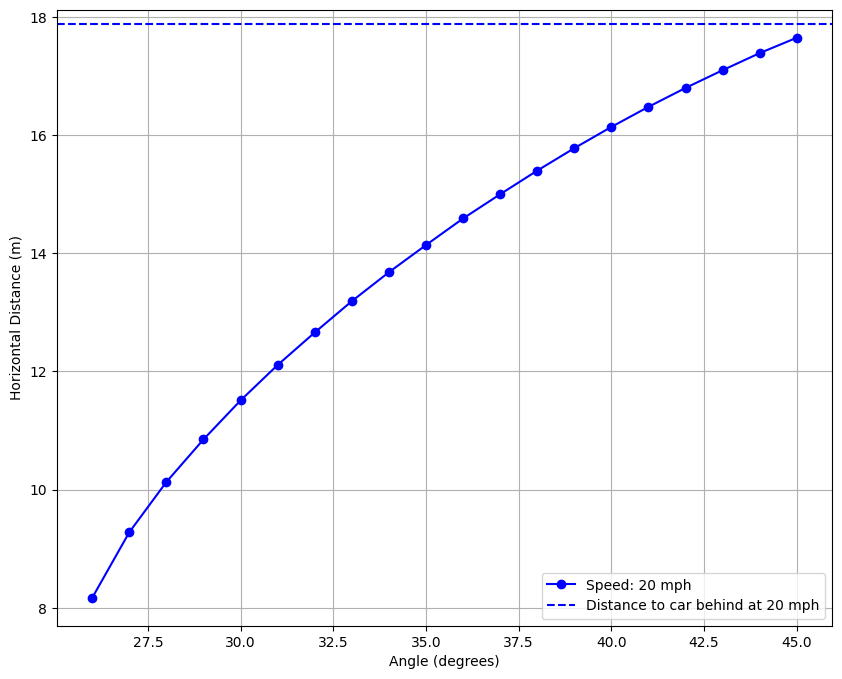

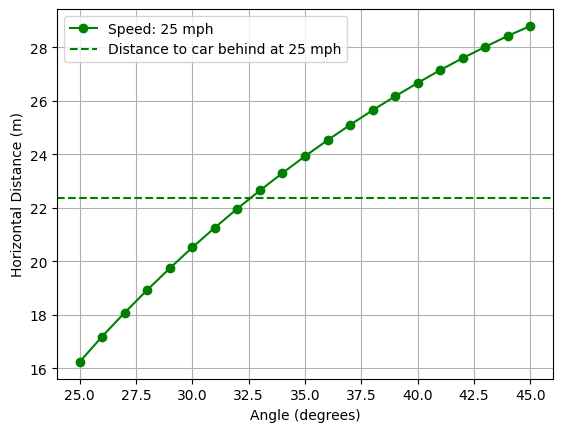

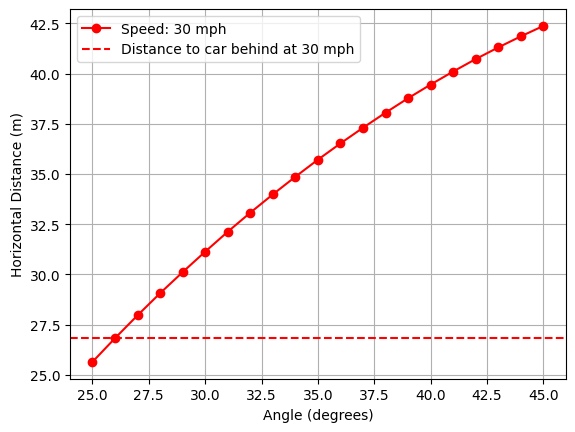

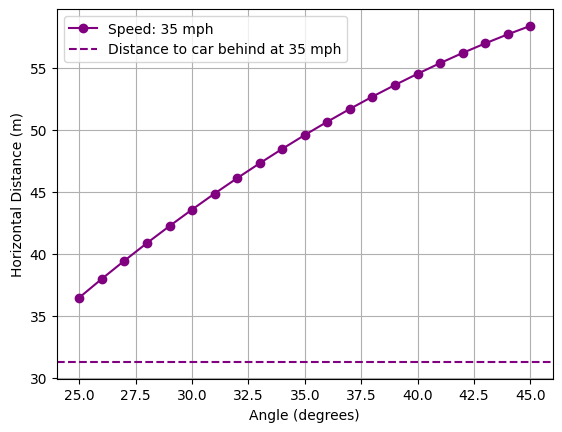

In [1]:
import math
from sympy import symbols, Eq, solve
import pandas as pd
from prettytable import PrettyTable
import matplotlib.pyplot as plt


y_target = 0.75  ##height of the bonnet
g = 9.81  ##acceleration due to gravity

angle_range = range(25, 46) ##Range of angles of projection
results = []
speedv = []
anglev = []
distv = []
timev = []

mph_range = range(20, 36, 5)
for mph in mph_range:
    ms = mph / 2.237  ##Convert mph to m/s

    ##Convert angle to radians
    for angle in angle_range:
        angle_rad = math.radians(angle)

        ##initial vertical component of velocity
        v_y0 = ms * math.sin(angle_rad)
        v_x = (ms * math.cos(angle_rad) ) + ms

        ##Define time 't'
        t = symbols('t')

        ##Vertical motion equation: y = v_y0 * t - (1/2) * g * t^2
        vertical_eq = Eq(v_y0 * t - (1/2) * g * t**2, y_target)
        t_values = solve(vertical_eq, t)

        ##Filter for positive real solutions
        valid_t_values = [t_value for t_value in t_values if t_value.is_real and t_value > 0]

        ##Calculate horizontal distance if valid solutions exist
        if valid_t_values:
            time = max(valid_t_values)  ##Maximum positive real time
            dist = v_x * time
        else:
            time = None
            dist = None

        timev.append(time)
        distv.append(dist)
        anglev.append(angle)
        speedv.append(mph)

        results.append({
            "speedmph": mph,
            "speed": ms,
            "angle": angle,
            "time_values": time,
            "horizontal_distances": dist
        })

##Prepare the data for the table and DataFrame
data = []
for result in results:
    angle = result["angle"]
    speed = result["speed"]
    speed1 = result["speedmph"]
    horizontal_distance = result["horizontal_distances"]
    rounded_dist = round(horizontal_distance, 2) if horizontal_distance is not None else None
    cardist = round(2 * speed, 2)
    if rounded_dist is None:
        damage = None
    elif rounded_dist <= cardist:
        damage = "No"
    else:
        damage = "Yes"

    ##Append the row data (with 5 columns)
    data.append([angle, speed1, rounded_dist, cardist, damage])

##Create a DataFrame with 5 columns
df = pd.DataFrame(data, columns=["Angle (degrees)", "Speed (mph)", "Horizontal Distance (m)", "Distance to Car (m)", "Damage Done? (Yes/No)"])
##Group by "Speed (mph)" and reset the index without duplicating the speed column
df = df.groupby("Speed (mph)").apply(lambda x: x)

##Highlight rows where "Damage Done?" is "Yes"
def highlight_damage(row):
    return ['background-color: yellow' if row['Damage Done? (Yes/No)'] == 'Yes' else '' for _ in row]

##Apply the styling
styled_df = df.style.apply(highlight_damage, axis=1)

##Save the styled DataFrame to an Excel file (requires openpyxl)
styled_df.to_excel("highlighted_damage.xlsx", engine='openpyxl', index=True)

##Save the unstyled DataFrame to a CSV file
df.to_csv("damage_data.csv", index=True)

##Plot the graphs

##Extract unique speeds
unique_speeds = df["Speed (mph)"].unique()

##Define colours for different speeds
colours = ["blue", "green", "red", "purple", "olive"]
colour_map = dict(zip(unique_speeds, colours))

##Calculate maximum safe distance before damage
df["Distance to Car (m)"] = 2 * (df["Speed (mph)"] / 2.237)

##Plot data for each speed
plt.figure(figsize=(10, 8))

for speed in unique_speeds:
    subset = df[df["Speed (mph)"] == speed]
    max_safe_distance = subset["Distance to Car (m)"].max()

    plt.plot(subset["Angle (degrees)"], subset["Horizontal Distance (m)"],
             marker='o', linestyle='-', color=colour_map[speed],
             label=f"Speed: {speed} mph")

    ##Add horizontal line for max safe distance
    plt.axhline(y=max_safe_distance, color=colour_map[speed], linestyle='--',
                label=f"Distance to car behind at {speed} mph")

    plt.xlabel("Angle (degrees)")
    plt.ylabel("Horizontal Distance (m)")
    #plt.title("Distance Chipping Travels vs Angle for Different Speeds")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"graph_{speed}.png")
    plt.show()

